## 0. 런타임 유형 변경, 패키지 설치와 데이터셋 설명 (Fashion-MNIST)

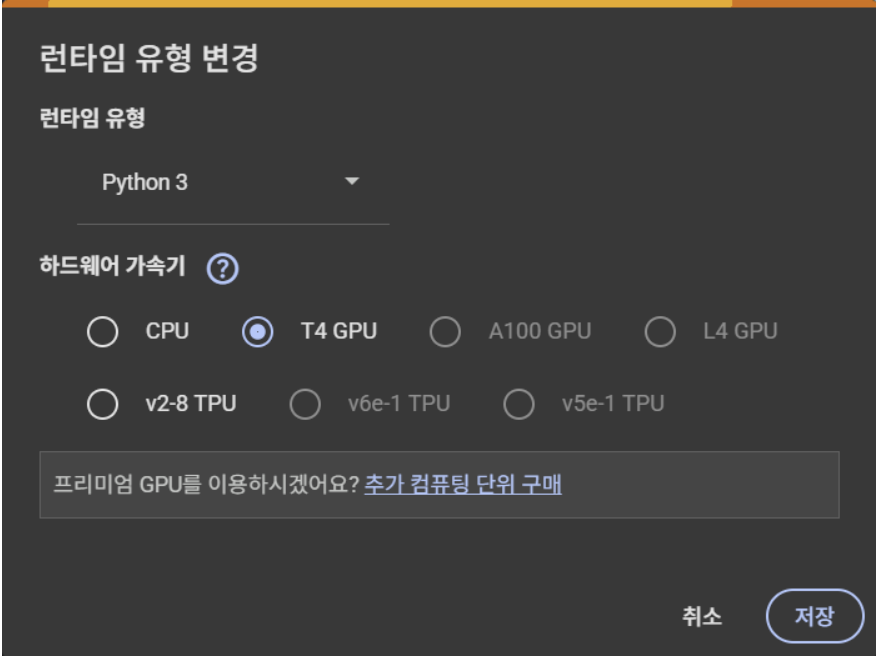

In [1]:
!pip install --upgrade --no-deps albumentations

- 모델을 활용하기 위해 GPU 환경이 필요해요.
- GPU를 사용하지 않고, CPU를 사용하면 시간이 아주 많이 걸립니다.
- colab에서 일정량을 무료로 사용할 수 있어요.

In [2]:
import torch
torch.cuda.is_available()

True

### Fashion-MNIST란?

모델을 만들고 실행할 GPU 환경을 만들었다면, 이제부터는 fashion-MNIST 모델에 대해서 먼저 알아보도록 합시다!

우선, MNIST는 Modified National Institute of Standards and Technology의 약자고, 손으로 쓴 숫자(0~9) 이미지 데이터셋을 의미해요.

그러면 Fashion-MNIST는 MNIST의 "의류 버전"입니다. 단순한 손글씨는 현실에서도 잘 쓰이지 않고, 지나치게 단순하기 때문에 새롭게 나온 개선 방안이라고 보시면 돼요. 기존 MNIST가 너무 단순해서 연구자들이 만든 더 현실적인 대체 데이터셋이에요.

### Fashion-MNIST label 구성
Fashion-MNIST 데이터셋은 다양한 의류 관련 사진들이 있고, 그 사진들을 label로 분류했습니다. 그리고 분류 기준은 아래와 같아요!

0	T-shirt/top

1	Trouser

2	Pullover

3	Dress

4	Coat

5	Sandal

6	Shirt

7	Sneaker

8	Bag

9	Ankle boot

## 1. MLP(다중 퍼셉트론)을 활용한 이미지 분류

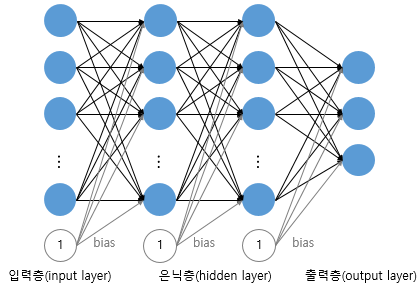

퍼셉트론은 실제 뇌를 구성하는 신경 세포 뉴런이 서로 연결되어 정보를 처리하는 구조를 모방한 것!

XOR문제보다 더 복잡한 문제를 해결하기 위해 다층 퍼셉트론은 중간에 수많은 은닉층을 더 추가할 수 있어요.

그리고 은닉층이 2개 이상인 신경망을 심층 신경망이라고 하고, 심층 신경망을 학습시키는 것을 딥러닝이라고 합니다.

**즉, 퍼셉트론 ⊂ MLP ⊂ 딥러닝 ⊂ 인공신경망**

### 데이터셋 불러오기

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# 데이터 전처리를 위한 변환을 정의합니다.
transform = torchvision.transforms.Compose([
    transforms.ToTensor(),               # 이미지를 PyTorch Tensor로 변환 (0~255 → 0~1 범위)
    transforms.Normalize((0.5,), (0.5,)) # 평균 0.5, 표준편차 0.5로 정규화 (데이터를 -1~1 범위로 조정)
])

# 학습 및 테스트 데이터셋 불러오기 (FashionMNIST로 변경)
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 178kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.13MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.0MB/s]


### 데이터셋 일부 시각화

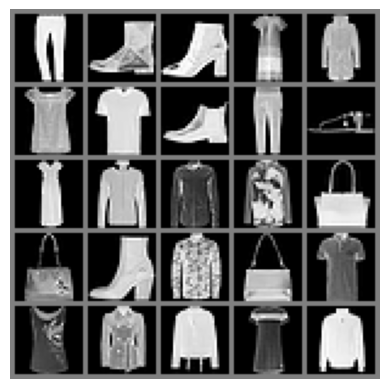

레이블:
Trouser      Ankle boot   Ankle boot   Dress        Coat         Shirt        T-shirt/top  Ankle boot   Trouser      Sandal       Dress        Coat         Shirt        Coat         Bag          Bag          Ankle boot   Shirt        Bag          T-shirt/top  T-shirt/top  Coat         Coat         Dress        Coat        


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋에서 일부 배치만 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Fashion-MNIST 클래스 이름
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 이미지를 보여주는 함수 정의
def imshow(img):
    img = img / 2 + 0.5     # 정규화 해제 (Normalize 복원)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()

# 64개 중 일부 (예: 상위 25개) 이미지를 5x5 격자로 시각화
imshow(torchvision.utils.make_grid(images[:25], nrow=5))

# 각 이미지에 해당하는 라벨 출력
print("레이블:")
print(' '.join(f'{classes[labels[j]]:12s}' for j in range(25)))


### train, valid, test 데이터셋 확인

기존 Fashion-MNIST 데이터셋은 train과 test 데이터로 나누어져 있어요.

우리는 이 데이터셋을 조금 더 나눠서 train, test, valid로 나누고, 간단하게 시각화해서 특징을 잡아보려고 해요.

그러면 학습 방향을 원활하게 설정할 수 있어요. (예를 들어, 바로 위에 시각화한 결과는 다 흑백이니까 데이터의 색상은 중요하지 않을 수 있어요.)

### ToTensor 및 정규화

MLP 학습 시 픽셀 값을 ToTensor를 통해서 0~1로 변환해야 해요.

그 이유는 픽셀 값의 범위는 0~255인데 (0이 검은색, 255는 흰색), MLP에 그대로 넣으면 값의 범위가 너무 커서 학습에 문제가 생길 수 있어요.

즉, 각 가중치와 입력값을 곱하다보면, 입력값이 너무 커지면 곱셈 결과가 너무 커서 gradient가 매우 커지게됩니다.

그리고 정규화 단계를 통해서 -1~1의 값으로 변환시키고, MLP의 학습을 안정시킬 수 있어요.

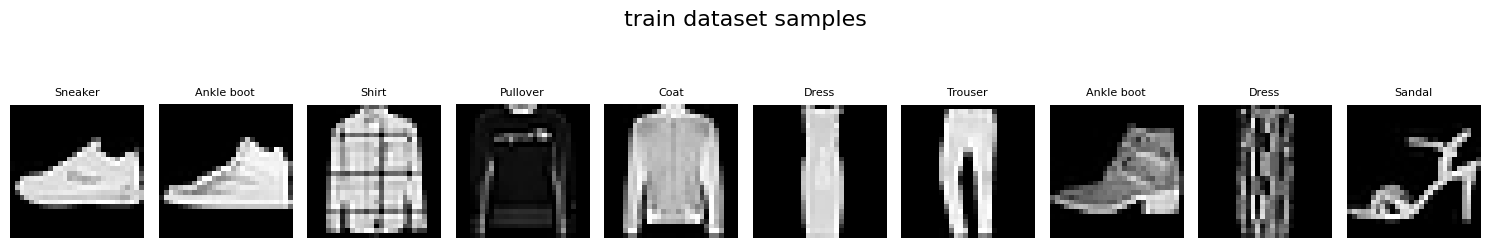

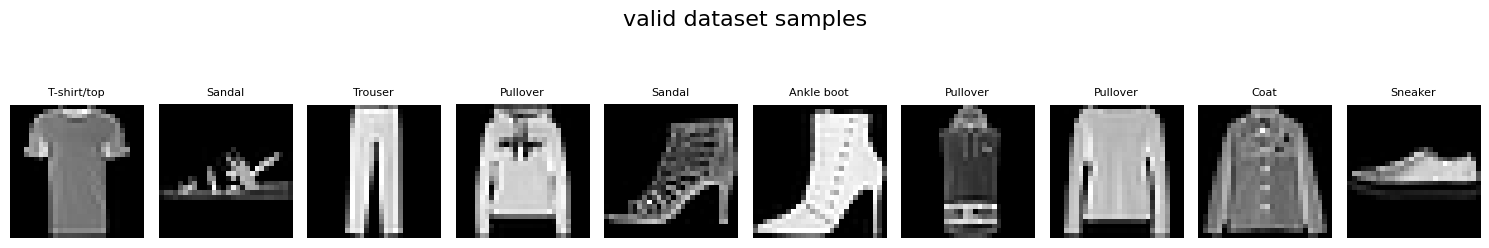

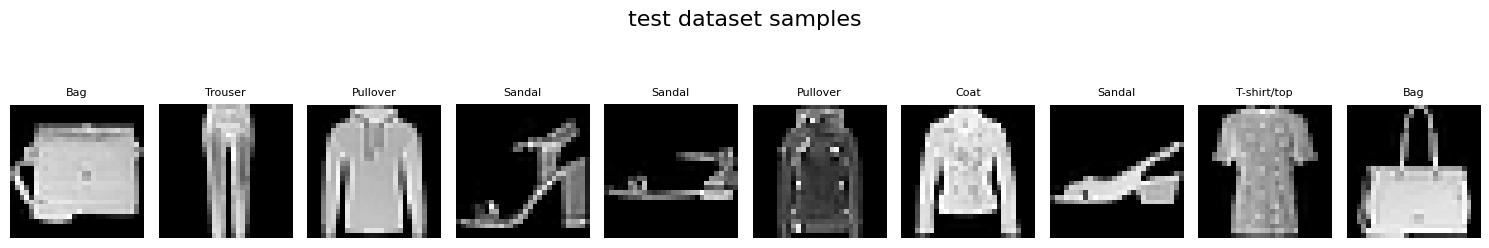

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1️ 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 2️ train에서 valid 분리 (80% train / 20% valid)
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

# 3️ 클래스 이름
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 4️ train/valid/test 딕셔너리
subsets = {'train': train_subset, 'valid': valid_subset, 'test': test_dataset}

# 5️ 시각화
for name, dataset in subsets.items():
    # 무작위 10개 샘플 인덱스
    indices = torch.randperm(len(dataset))[:10]

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"{name} dataset samples", fontsize=16)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        plt.subplot(1, 10, i+1)
        plt.imshow(img.squeeze(), cmap='gray')  # 1채널 흑백 이미지
        plt.title(classes[label], fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


바로 위 코드를 통해 기존 train과 test로 나누어져 있던 데이터셋에서 train 데이터의 20%를 가져와서 검증용 데이터를 추가했어요.

그러면 train은 48000, valid는 12000, test는 10000이 됩니다!

### DataLoader

PyTorch에서 DataLoader는 데이터셋에서 데이터를 미니배치 단위로 꺼내주고, train/valid/test용으로 섞거나 순서대로 제공해줘요.

즉, Dataset에 대해서 배치 단위로 꺼내고, 내용을 섞는 역할을 수행합니다.

그리고 shuffle옵션의 경우, train데이터셋에 대해서 True를 적용해야해요.

왜냐하면 학습 시에는 매 epoch마다 데이터 순서를 섞어야 하는데, 그렇지 않으면 배치에 특정 클래스만 포함될 수 있고, 모델이 편향될 수 있기 때문입니다.

에포크와 배치
- 에포크
: 전체 학습 데이터셋을 한 번 모델에 통과시키는 단위

- 배치(Batch)
:전체 데이터셋을 작은 단위(batch)로 나누어 학습


In [23]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_subset, batch_size=16, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, num_workers=2)

### train, validate 함수정의

train 함수를 통해서 모델을 학습 모드로 전환하거나, 검증 모드로 전환해서 그 루틴을 함수로 만들어서 반복적으로 사용 가능하게 만들어야 해요.

학습 과정에서는 손실과 정확도를 계산해서 epoch_loss와 epoch_acc를 출력하고, 검증 과정에서도 검증 데이터로 손실과 정확도를 계산할 수 있어요.

### 여기서 epoch란?

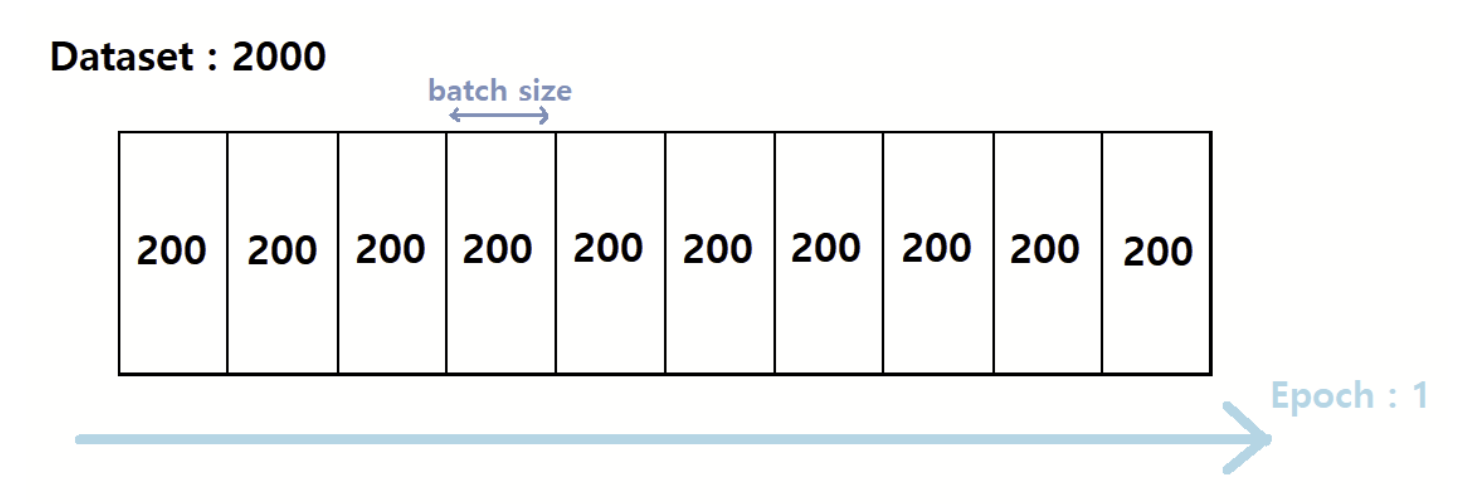

강의 자료에서 이야기한 것처럼, "모든 데이터셋을 학습하는 횟수"를 의미합니다.

1 epoch의 학습은 데이터셋을 1번 학습한다라고 이해하시면 됩니다.

다시, train, validate 함수로 돌아와서...

train()의 핵심 내용
- model.train(): 모델을 학습 모드로 설정합니다
- optimizer.zero_grad(): 이전 step에서 계산된 gradient를 0으로 초기화합니다.<br>
  이전에 계산된 정보를 지우는 부분이에요
- loss.backward(): 역전파를 수행합니다
- optimizer.step(): 계산된 gradient를 이용해 모델의 parameter를 업데이트합니다.

### 역전파는?

쉽게 설명하면, 정답을 보고 틀린 문제를 다시 학습하는 과정을 의미합니다.

즉, 예측을 먼저 수행했을 때, 정답과 비교해보고, 다시 틀린 문제를 학습하는 것을 의미합니다!

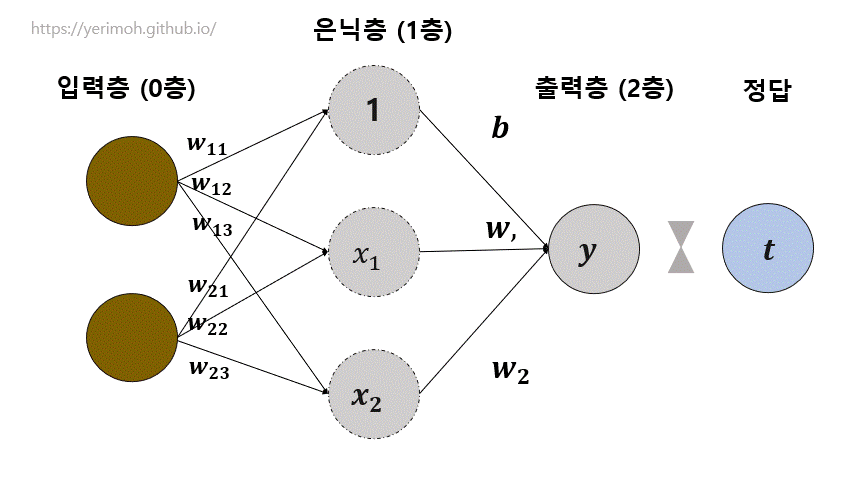

In [24]:
from tqdm import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, criterion, optimizer, train_loader): # 학습 모드 설정
    model.train()
    running_loss = 0.0
    corrects = 0
    total_samples = 0

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        batch_size = labels.size(0)

        optimizer.zero_grad()  # 이전 배치의 기울기 초기화
        outputs = model(images)
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파(backward)
        optimizer.step()  # 옵티마이저로 가중치 갱신

        running_loss += loss.item() * batch_size
        preds = torch.argmax(outputs, dim=1)
        corrects += (preds == labels).sum().item()
        total_samples += batch_size

    epoch_loss = running_loss / total_samples
    epoch_acc = corrects / total_samples
    return epoch_loss, epoch_acc


def validate(model, criterion, val_loader): # 평가 모드 설정
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    total_samples = 0

    with torch.no_grad(): # 검증의 경우 기울기 계산 불필요
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            batch_size = labels.size(0)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += val_loss + loss.item() * batch_size
            preds = torch.argmax(outputs, dim=1)
            val_corrects += (preds == labels).sum().item()
            total_samples += batch_size

    epoch_loss = val_loss / total_samples
    epoch_acc = val_corrects / total_samples
    return epoch_loss, epoch_acc

### save_checkpoint 함수정의

save_checkpoint 함수를 통해서 현재 epoch를 저장해서 나중에 이어서 학습이 가능하도록 만들 수 있어요.

그리고 모델 가중치를 저장해서 나중에 불러와서 바로 평가하거나 추론이 가능합니다!

그리고 Train/Validation Loss와 Accuracy를 기록함으로써 학습의 곡선을 시각화할 수 있어요.

즉

1) 모델이 잘 학습되었는지 확인하고

2) 학습 도중 GPU 세션이 종료되어도 다시 이어서 학습할 수 있도록 하고

3) 최고 성능의 모델만 저장할 수 있도록 만들 수 있어요.

In [25]:
def save_checkpoint(epoch, model, save_path, train_losses, val_losses, train_accuracies, val_accuracies):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'train_losses': train_losses,  # Train Loss 저장
        'val_losses': val_losses,      # Validation Loss 저장
        'train_accuracies': train_accuracies,  # Train Accuracy 저장
        'val_accuracies': val_accuracies       # Validation Accuracy 저장
    }
    torch.save(checkpoint, save_path)

### 모델 준비
먼저 모델의 구조를 살펴볼게요.


모델 구조
mlp

입력층: 28×28 픽셀 이미지를 784차원 벡터로 변환

은닉층 3개:

fc1: 784 → 256

fc2: 256 → 128

fc3: 128 → 64

출력층: fc4: 64 → 10

활성화 함수

은닉층에서 ReLU(Rectified Linear Unit) 적용 → 비선형성 추가



In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1️ MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)  # Fashion-MNIST 클래스 수 = 10

    def forward(self, x):
        x = x.view(-1, 28*28)  # 1채널 28x28 이미지 → 784차원 벡터
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = MLP()

# 2️ GPU로 옮기기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 3️ 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류
optimizer = optim.Adam(model.parameters(), lr=0.001)  # MLP는 모든 파라미터 학습

### 손실함수란?

손실 함수(Loss Function)는 모델 출력과 실제 값의 차이를 수치로 나타낸 함수를 의미합니다.

손실함수로는 평균제곱오차(MSE), 이진 크로스 엔트로피(BCE), 크로스 엔트로피 오차가 있습니다.

1) 평균제곱오차:
예측 값이 연속적이고 예측 값과 실제 값 차이를 직접적으로 측정하는 '회귀 문제'에 적합합니다.

2) 이진 크로스 엔트로피:
이진 분류 문제에서 사용합니다.
또한, 실제 정답이 1일 때와 실제 정답이 0일때 각 Loss의 값은 예측 확률에 따라 달라집니다. (정답이 1일때, 예측을 1에 가깝게 예측하면 loss는 0에 수렴)

3) 크로스 엔트로피 오차:
다중 클래스 분류에서 활용하는 모델입니다.


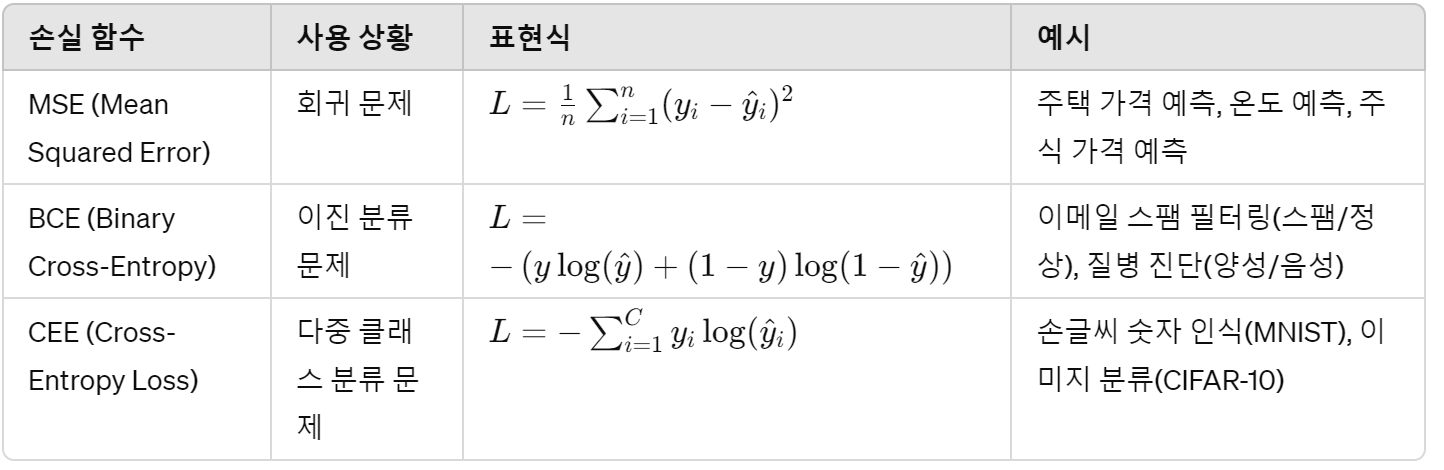

### 옵티마이저란?


옵티마이저는 경사하강법을 더 효율적이고, 안정적으로 수행할 수 있도록 하는 것!

경사하강법을 어떻게 하는지 (=어떤 옵티마이저를 사용하는지)에 따라서 최솟값을 찾아가는 방식이 달라집니다.

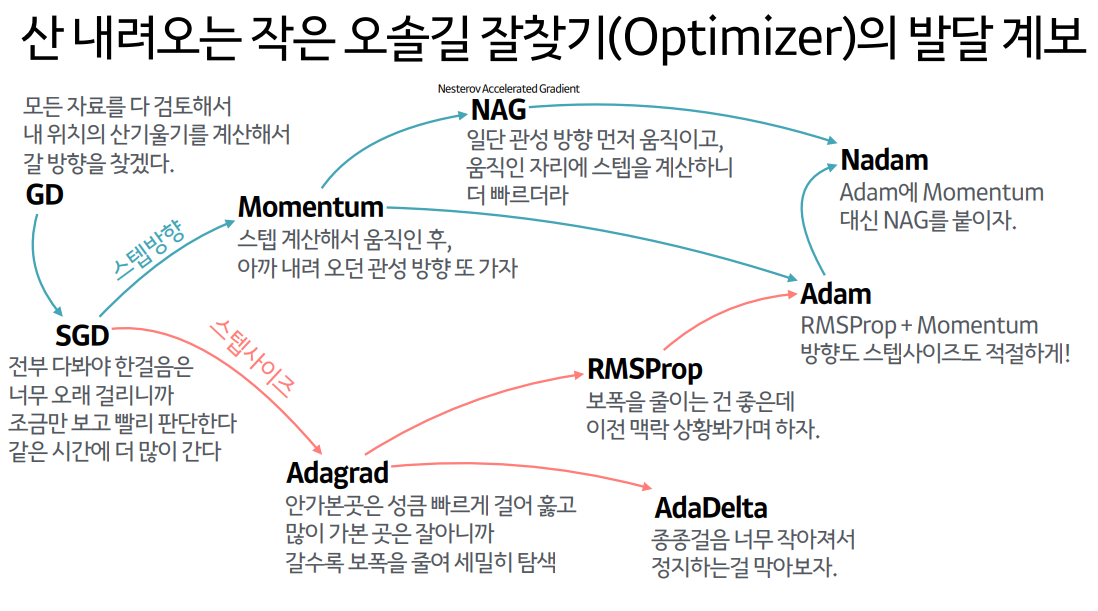

### 학습 시작

Epoch 1/20, Train Loss: 0.5301, Train Accuracy: 0.8057, Validation Loss: 3428460134765490370918123627974792313390538754621693584895088931969886220078675038110246030371962304800700977466746510394245369818257410980057734276951121026389031045239838654701464406532906320193770029068284577524305887232.0000, Validation Accuracy: 0.8349


Epoch 2/20, Train Loss: 0.3960, Train Accuracy: 0.8543, Validation Loss: 3202076872558581146089658783627125893320258654050061481485817025591668226868324726915822727551897497029544847476806215035608783566676540961653479088010341587129599083264821349129578716036238200272919823176648972499402358784.0000, Validation Accuracy: 0.8492


Epoch 3/20, Train Loss: 0.3521, Train Accuracy: 0.8707, Validation Loss: 2740969745393299505157093138979760219565751784249794866860033682442729063366355998401230930402625732897703911763971889255502092973418777046168909450956511560320281829205200013155336300452328828113482715668288508071090585600.0000, Validation Accuracy: 0.8682


Epoch 4/20, Train Loss: 0.3259, Train Accuracy: 0.8792, Validation Loss: 2525649213212620128142439807692188042116352423848890149770683737839238228530066267294173207089126114033593248442083059242645122097458461347932279714667130112770928707312228665926436665174469961257747750381527907795021594624.0000, Validation Accuracy: 0.8692


Epoch 5/20, Train Loss: 0.3047, Train Accuracy: 0.8869, Validation Loss: 2037735735927698395253696503379832958806238850694564694111609902904642498460421182156693963520612723447129057012811800459479226779310872927409140988172308717836249715970993466004138037839068668833534452980877873389798162432.0000, Validation Accuracy: 0.8779


Epoch 6/20, Train Loss: 0.2896, Train Accuracy: 0.8919, Validation Loss: 2567731110772922856585122136980870676605782281866708272768057417111463986535590862320072001954356543612138395084112317009426815821141363439771350377344130911796619770933661464055447593748803705171285318527301419483751514112.0000, Validation Accuracy: 0.8788


Epoch 7/20, Train Loss: 0.2765, Train Accuracy: 0.8972, Validation Loss: 2558960984521732736726539101924939153161595114967536790051780201345407873178737325075992016826068801650906548027378477720894690841063621382095467315853387159986324516833340478608882622579542402946455686181197105193711304704.0000, Validation Accuracy: 0.8796


Epoch 8/20, Train Loss: 0.2692, Train Accuracy: 0.8984, Validation Loss: 2452642623843099515160985744132806562690842158611715526134905839348134577305630762790722962203964637412256240583631949146561211925374266198539733780550110609167966197119463805944616976658971652006713831185248437892955504640.0000, Validation Accuracy: 0.8794


Epoch 9/20, Train Loss: 0.2570, Train Accuracy: 0.9035, Validation Loss: 1997112584831323085752353555683961449132941735061794755969413351860224166837900666875107548427398285026337913104431338576152274453922818163429317342701628187161307669611599559139728167078868758406852187415760323168719339520.0000, Validation Accuracy: 0.8845


Epoch 10/20, Train Loss: 0.2467, Train Accuracy: 0.9080, Validation Loss: 2688055859553568173652978091349205076326530294741626840574340518365404892773881805832560172778474995246127744373944242331187720641868322658520714336896121921581261336541852900322877658067034897683396892867758463711430311936.0000, Validation Accuracy: 0.8796


Epoch 11/20, Train Loss: 0.2386, Train Accuracy: 0.9106, Validation Loss: 3050686166645240976495457192661818973103068955748605658319775317632675969319128466964042363875948741641199491476957193654249804497206628725542674848969807402255408356951321272900245790509131372849465865841166325632276103168.0000, Validation Accuracy: 0.8821


Epoch 12/20, Train Loss: 0.2293, Train Accuracy: 0.9132, Validation Loss: 2651155073822449500635883390085064855081163450249562483591823839821383101040305786851027267405573799425135483613995250043635542414116318660698054135593092446163920941533160921862130241164867243702906489242194338941293821952.0000, Validation Accuracy: 0.8884


Epoch 13/20, Train Loss: 0.2229, Train Accuracy: 0.9171, Validation Loss: 2915336931564975723569939316258426022327647237245291730194377644590588566136548042757435426246129609447064953198396215807686165018712546343504535945893988544088057833478498046161553944027080331390511343601114245100067618816.0000, Validation Accuracy: 0.8774


Epoch 14/20, Train Loss: 0.2183, Train Accuracy: 0.9180, Validation Loss: 2965626162280166838897847952057703377786674613955435715305017539644153100785344935474688726989617536190716583349333390099480816921895467740155928823241215156554419110645731938983291297925766679922349017598130709218184921088.0000, Validation Accuracy: 0.8912
Early stopping triggered.


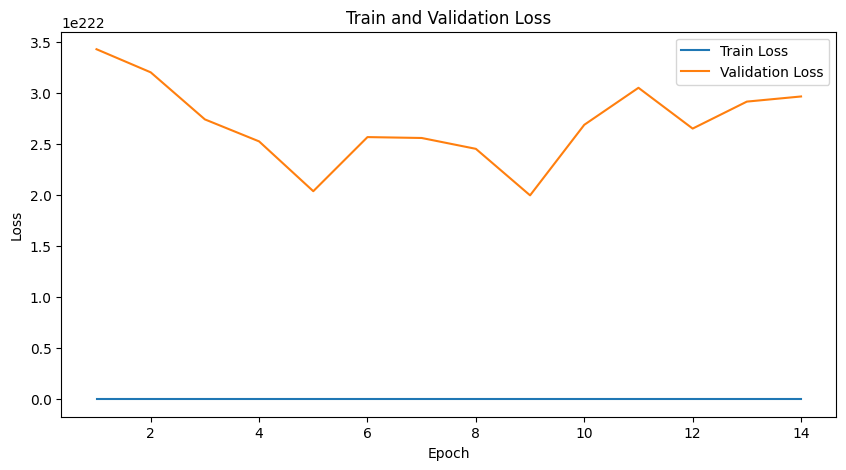

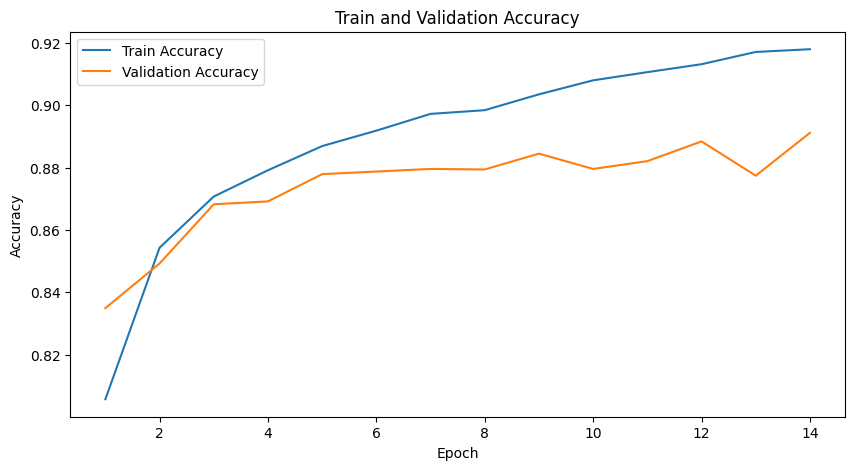

In [27]:
# 4. 학습 루프 준비
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

num_epochs = 20 #전체 반복 횟수 설정
early_stop_patience = 5 # 조기 종료 조건, 5번 연속 성능이 개선되지 않으면 조기 종료. 과적합 방지
best_val_loss = float('inf')
early_stop_counter = 0

# 5. 학습 및 검증 루프
for epoch in range(num_epochs): #1번의 학습 동안 학습과 검증을 수행
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    val_loss, val_acc = validate(model, criterion, valid_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)  # float 그대로 저장
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping (조기종료조건)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        save_path = f"./fashion_mnist_epoch_{epoch+1}.pth"  # 로컬 저장
        save_checkpoint(epoch+1, model, save_path,
                        train_losses, val_losses,
                        train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# 전체 epoch 완료 후 모델 저장
if early_stop_counter < early_stop_patience:
    print("전체 epoch 완료 후 모델 저장")
    save_path = f"./fashion_mnist_final_epoch_{num_epochs}.pth"
    save_checkpoint(num_epochs, model, save_path,
                    train_losses, val_losses,
                    train_accuracies, val_accuracies)

# 6. 손실 그래프 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# 7. 정확도 그래프 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

### 상황 설명

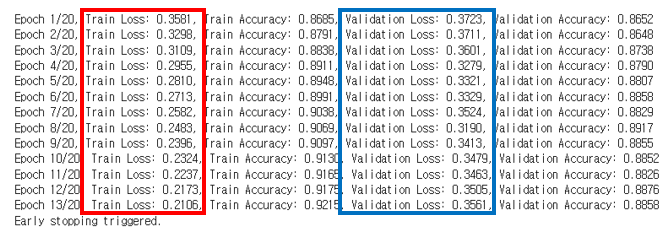



- Train Loss를 보면 Epoch를 지날수록 점차 줄어드는 것을 확인할 수 있어요.

- 그런데, Train Loss는 점차 줄어드는데, Validation Loss는 학습 중간에 커지는 상황이 발생하는데, 이를 '과적합'이라고 해요.

- 저는 Epoch 13까지 학습하고 종료 조건에 의해서 종료되었는데, 개개인마다 조기종료는 다를 수 있어요.

### test 데이터셋 평가

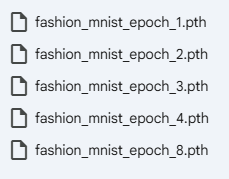

학습이 끝난 후 제 드라이브 안에 있는 파일들이에요.

만약 final이라는 이름이 들어간 파일이 있따면 그 파일을 쓰시면 되고, final 파일 없이 위 사진처럼 있다면, epoch 뒤의 숫자가 가장 큰 파일을 사용하시면 됩니다!

In [30]:
# 1. 모델 가중치 로드
load_path = "./fashion_mnist_epoch_9.pth"  # 로컬에 저장한 모델 파일
checkpoint = torch.load(load_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# 2. 테스트 데이터셋 평가
test_loss = 0.0
test_corrects = 0
criterion = nn.CrossEntropyLoss() #다중분류의 손실함수
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch_size = labels.size(0)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * batch_size
        preds = torch.argmax(outputs, dim=1)
        test_corrects += torch.sum(preds == labels).item()
        total_samples += batch_size

# 3. 평균 손실과 정확도 계산
test_loss /= total_samples
test_acc = test_corrects / total_samples

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3656, Test Accuracy: 0.8756


### 성능 지표 계산

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np

# 1. 예측 결과와 실제 라벨 저장
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 2. 클래스 이름 리스트
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 3. 분류 보고서 출력
print(classification_report(all_labels, all_preds, target_names=classes))

# 4. 혼동 행렬
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)


              precision    recall  f1-score   support

 T-shirt/top       0.81      0.81      0.81      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.74      0.87      0.80      1000
       Dress       0.87      0.89      0.88      1000
        Coat       0.82      0.80      0.81      1000
      Sandal       0.95      0.94      0.94      1000
       Shirt       0.75      0.61      0.67      1000
     Sneaker       0.91      0.96      0.93      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000

Confusion Matrix:
[[813   2  30  28   3   2 116   0   6   0]
 [  2 969   1  22   3   0   2   0   1   0]
 [ 18   1 874  10  58   1  34   0   4   0]
 [ 32   8  11 893  30   2  18   1   5   0]
 [  0   1 128  44 795   0  28   0   4   0]
 [  0   

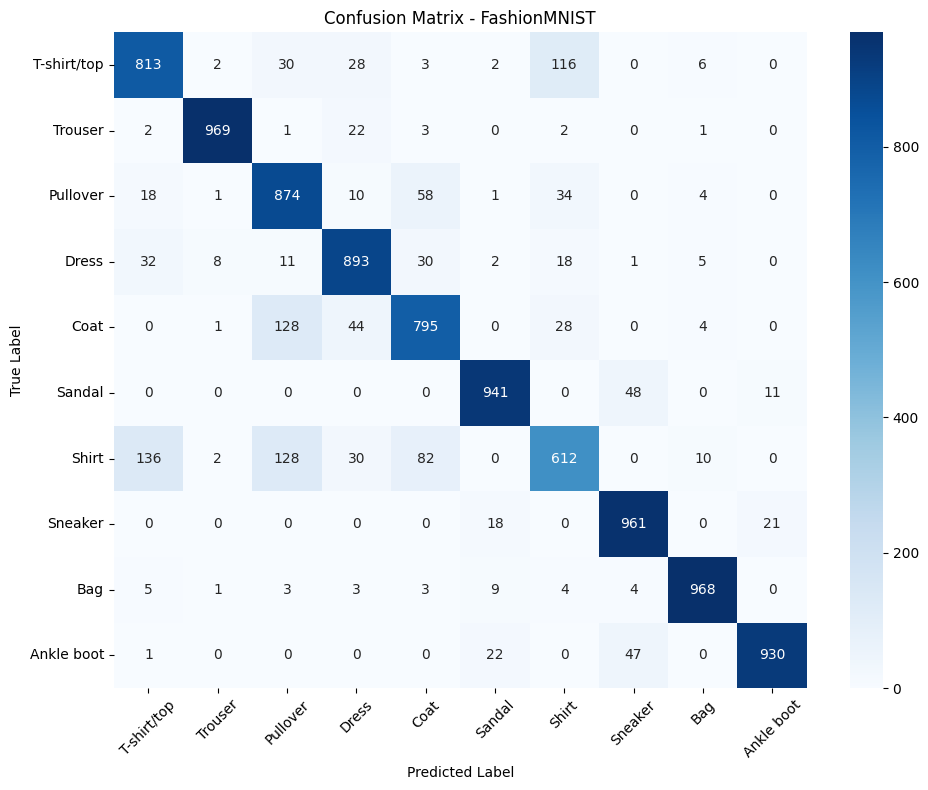

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 혼동 행렬 계산
cm = confusion_matrix(all_labels, all_preds)

# 2. 클래스 이름
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 3. 혼동 행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - FashionMNIST')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### test 데이터셋에서 예측값과 정답을 시각화를 통해 비교

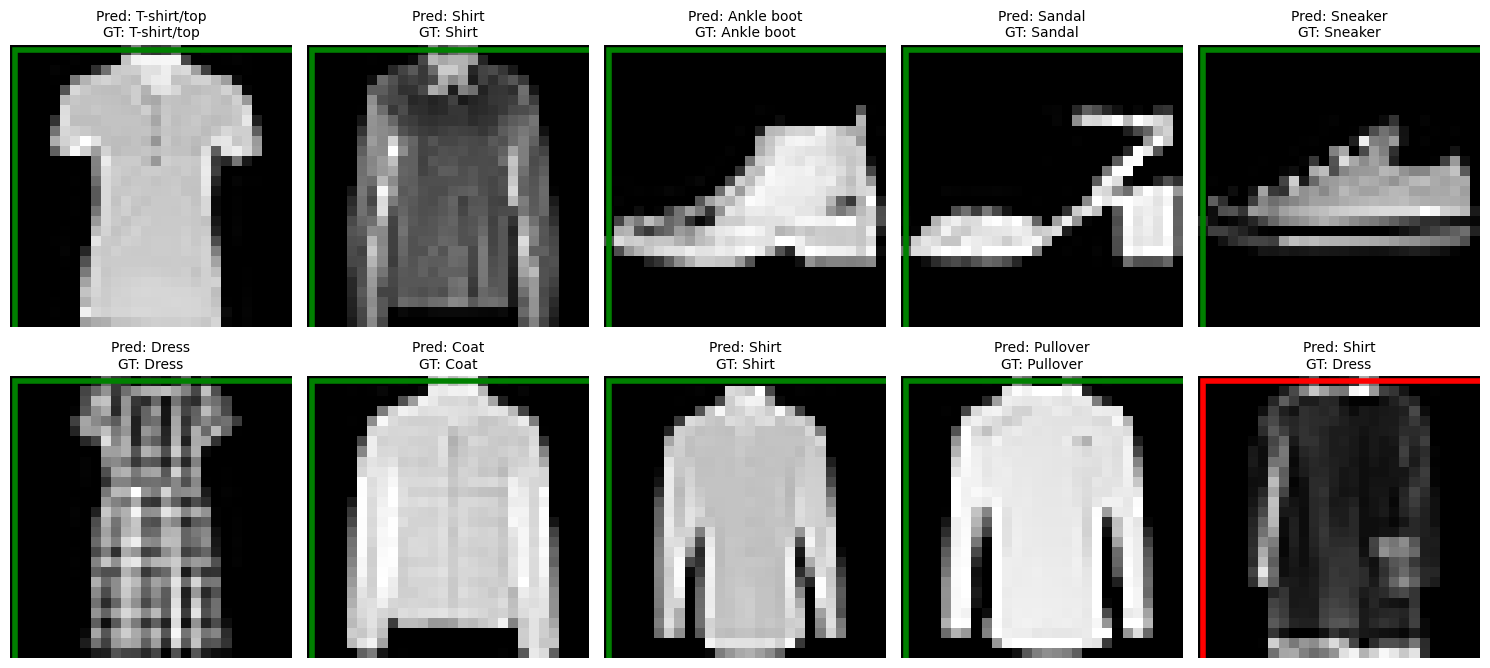

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np

# 시각화 설정
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(15, 7))  # 2행 5열 subplot
axes = axes.ravel()

random_indices = random.sample(range(len(test_dataset)), 10)

for i, idx in enumerate(random_indices):
    image, label = test_dataset[idx]  # image: tensor, label: int
    input_tensor = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    # 클래스 이름 매핑
    pred_class = classes[pred]
    gt_class = classes[label]

    # 이미지 처리: CHW → HWC, 흑백이므로 squeeze
    image_np = image.squeeze().cpu().numpy()

    axes[i].imshow(image_np, cmap='gray')
    axes[i].axis("off")
    axes[i].set_title(f"Pred: {pred_class}\nGT: {gt_class}", fontsize=10)

    # 테두리 색상: 정답이면 초록, 오답이면 빨강
    color = "green" if pred == label else "red"
    h, w = image_np.shape
    rect = patches.Rectangle((0, 0), w, h, linewidth=4, edgecolor=color, facecolor='none')
    axes[i].add_patch(rect)

plt.tight_layout()
plt.show()


## 2. CNN을 활용한 이미지 분류

위에서는 다중 퍼셉트론(MLP)을 활용해서 이미지 분류를 수행했어요.

그런데, MLP는 입력 이미지를 1차원 벡터로 변환하기 때문에 공간 구조를 잃어버리게 됩니다.

따라서 CNN을 활용하면 이미지의 지역 패턴 (가장자리, 질감, 모서리 등)을 학습할 수 있고, 이미지의 공간 정보를 활용할 수 있어요.

### 데이터셋 불러오기

In [35]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


# 1. 데이터 전처리
# CNN에서는 2D 구조 그대로 사용
transform = torchvision.transforms.Compose([
    transforms.ToTensor(),  # [0,1]로 변환 후 Tensor
    transforms.Normalize((0.5,), (0.5,))  # 평균 0.5, std 0.5로 정규화
])

# 2. 학습/테스트 데이터셋
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

### ToTensor, 정규화 및 train, valid, test데이터셋 분리

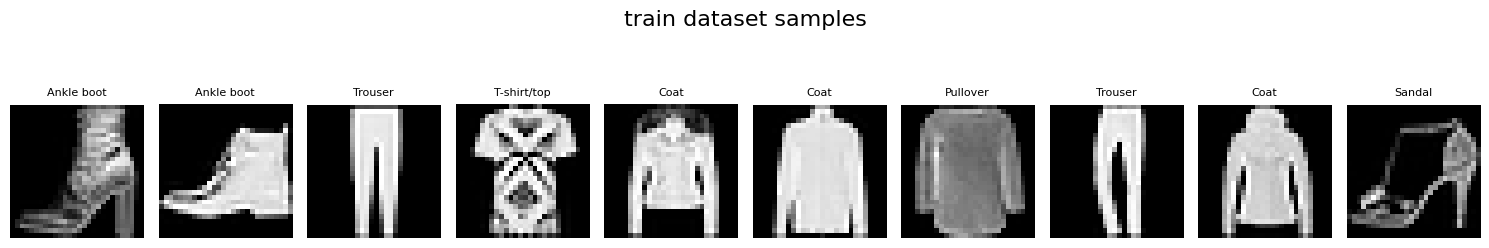

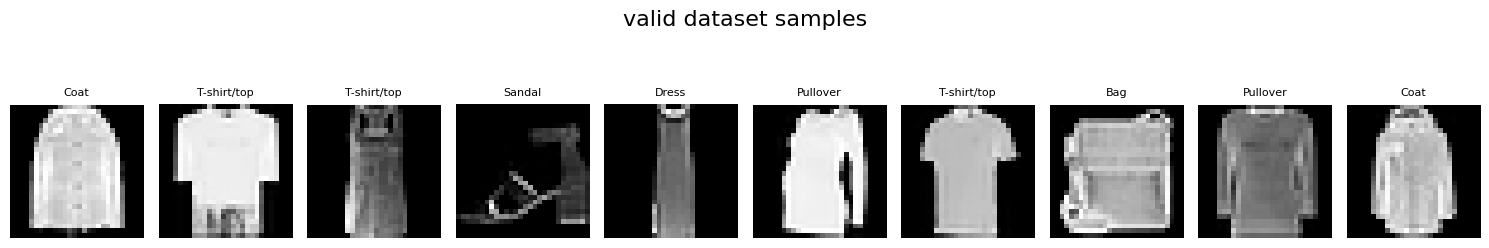

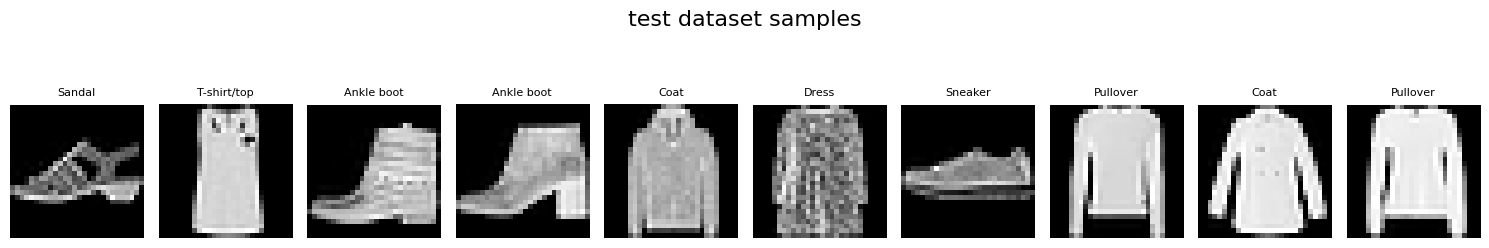

In [36]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. 데이터 전처리 (ToTensor + 정규화)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 2. 학습/테스트 데이터셋
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# 3. train/valid 분리 (80% / 20%)
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

# 4. 클래스 이름 정의
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 5. 데이터 시각화 (무작위 10개 샘플 확인)
subsets = {'train': train_subset, 'valid': valid_subset, 'test': test_dataset}

for name, dataset in subsets.items():
    indices = torch.randperm(len(dataset))[:10]  # 무작위 10개 샘플
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"{name} dataset samples", fontsize=16)

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        plt.subplot(1, 10, i+1)
        plt.imshow(img.squeeze(), cmap='gray')  # 1채널 흑백 이미지
        plt.title(classes[label], fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


### DataLoader

MLP를 활용한 이미지 분류에서와 마찬가지로 데이터를 배치단위로나누고, 데이터를 섞어서 epoch 단위로 반복 가능하게 해줍니다.

In [37]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_subset, batch_size=16, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False, num_workers=2)

### train, validate, save_checkpoint 함수설정

train, validate, save_checkpoint 함수는 앞서 MLP를 활용한 이미지 분류 당시 만들었던 함수를 그대로 사용합니다.

### 모덷 준비

### nn.Conv2d() 설명 - CNN에서 이미지의 특성을 추출하기 위한 2차원 합성곱 연산

예시: nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=4, padding=1)

주요 파라미터
- in_channels: 입력 이미지의 채널 개수
- out_channels: 출력 이미지의 채널 개수
- kernel_size: 커널(필터)의 크기
- stride: 점프 얼마나 할건지
- padding: 이미지 겉에 0의 테두리를 얼마나 추가할건지

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1️ CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 입력: 1x28x28
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 출력: 32x28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 출력: 64x28x28
        self.pool = nn.MaxPool2d(2, 2)                            # 64x14x14
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 128x14x14
        self.pool2 = nn.MaxPool2d(2, 2)                           # 128x7x7

        self.fc1 = nn.Linear(128*7*7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # Fashion-MNIST 클래스 수 = 10

    def forward(self, x): #순전파 정의
        x = torch.relu(self.conv1(x)) #conv1 + ReLU를 활성화
        x = torch.relu(self.conv2(x)) #conv2 + ReLU를 활성화
        x = self.pool(x) #첫 번째 풀링을 수행
        x = torch.relu(self.conv3(x)) #conv3 + ReLU를 활성화
        x = self.pool2(x) #두 번째 풀링을 수행
        x = x.view(-1, 128*7*7)  # Flatten: 2D -> 1D 벡터
        x = torch.relu(self.fc1(x)) #fc1 + ReLU를 활성화
        x = torch.relu(self.fc2(x)) #fc2 + ReLU를 활성화
        x = self.fc3(x) #fc3 -> 최종 출력
        return x

model = CNN()

# 2️ GPU로 옮기기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 3️ 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류를 위한 크로스엔트로피 손실함수 사용
optimizer = optim.Adam(model.parameters(), lr=0.001) #옵티마이저로 주로 사용하는 것

### 학습 시작

Epoch 1/20, Train Loss: 0.4019, Train Accuracy: 0.8506, Validation Loss: 735958703805270430596604115950145586272081409150481024789000826657104644198584618885459103116501249698956295250817742142435612640081517477490459639514764733435336272394821801537840283325900299423413963391225045523347013632.0000, Validation Accuracy: 0.8986


Epoch 2/20, Train Loss: 0.2446, Train Accuracy: 0.9111, Validation Loss: 529014541270112311156193232280778467888841521881262914351440046087407306553376779945710756710388668694441431712314413865701535387983448396795580297126804041510344583443977885982424784650618400104684187540002356325865488384.0000, Validation Accuracy: 0.9142


Epoch 3/20, Train Loss: 0.1938, Train Accuracy: 0.9290, Validation Loss: 687045485979207056562092084481597311799695081026934345119970322064182151368477511883642326558039162925821505502677445029133351321852381161057837809167200094841847530273895886442370089724906060452740287864919893606341279744.0000, Validation Accuracy: 0.9179


Epoch 4/20, Train Loss: 0.1550, Train Accuracy: 0.9431, Validation Loss: 490750939090149019432319030927589708740860263801363343848093247822890050516902227710691108717866701415079574152817390283286210048148979461397008115941829528114832203636793141070563052931054514190040132038599818057994993664.0000, Validation Accuracy: 0.9216


Epoch 5/20, Train Loss: 0.1262, Train Accuracy: 0.9531, Validation Loss: 547003208336334169596014792122786432252588596577083743913063138622580579473077812059769151500176546797569795130484845862763167171213310548307892558932183554326995514549747988462567271821259264787365298699480636754982076416.0000, Validation Accuracy: 0.9218


Epoch 6/20, Train Loss: 0.1032, Train Accuracy: 0.9623, Validation Loss: 603299494952453283774707763361370741630456274154106113379277043224794286727856466105681294976253543415082856730805305664239977789390375091085428210418885549655680024028906472802413741983114645066211512841353835946123984896.0000, Validation Accuracy: 0.9236


Epoch 7/20, Train Loss: 0.0870, Train Accuracy: 0.9694, Validation Loss: 956085580753984580726449030148843183234707172773629351426128554030352399663210852652958800086562571778861522829378468214635263421497013053060112963320054396475143485981936977298045111725875521775654795535319508067146530816.0000, Validation Accuracy: 0.9258


Epoch 8/20, Train Loss: 0.0761, Train Accuracy: 0.9729, Validation Loss: 973968329579476157515909568866703713796858581027108469258171173414702434644538990986654413284825612431448529443488212653791782121445177563282245732814754452837825306902789552051467615476477543479390701880483110999061168128.0000, Validation Accuracy: 0.9253


Epoch 9/20, Train Loss: 0.0598, Train Accuracy: 0.9775, Validation Loss: 286579000211528700259716628068587925939573910531459972573907564333590863640370860237972919586194772296386239164153401305215867596713751648799810194655210159776049237043440397671565174425996341663118257132573707527469924352.0000, Validation Accuracy: 0.9256


Epoch 10/20, Train Loss: 0.0570, Train Accuracy: 0.9801, Validation Loss: 1068573582064074098101401181441004383776524697094260022245920610673119171884750866648933780381721050377940394096927996943381043054330310734368985809100039072475174033856232065267693390771360687268209061363480358447566815232.0000, Validation Accuracy: 0.9223


Epoch 11/20, Train Loss: 0.0502, Train Accuracy: 0.9825, Validation Loss: 381558876605390743777113431621015879825868742195284269048327702999170394475219383275281405219354453349157914191989699107552256743783565854877189400543464202490733452731442971369143081312047171030121452402616303493324996608.0000, Validation Accuracy: 0.9244


Epoch 12/20, Train Loss: 0.0457, Train Accuracy: 0.9847, Validation Loss: 1275674277262268711558697338130457900941061438729835026147392852076137593728700817519299664655919224324714928044198775979083575830335885369725935356382495459255914483187621354676752436319849639296945364889258436204548849664.0000, Validation Accuracy: 0.9210


Epoch 13/20, Train Loss: 0.0428, Train Accuracy: 0.9862, Validation Loss: 1660272241785697739092224942036400241972175380260578543744738037438198350118963457593322065377388850787768327822719979624297643704849368869987105260073690127506651929790158399366790785276228116669594564757801167379736035328.0000, Validation Accuracy: 0.9227


Epoch 14/20, Train Loss: 0.0425, Train Accuracy: 0.9861, Validation Loss: 1774661520735961959720688939822298739629892047764767203210691853132773391356125442370710359765946560760240618664145998123847340705175933825318303265942578362466264602484677052286342024404541564107402563757253653512715239424.0000, Validation Accuracy: 0.9235
Early stopping triggered.


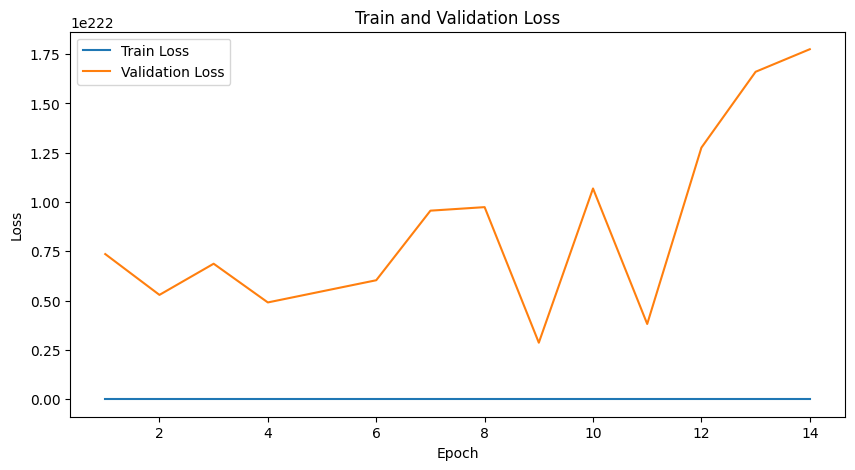

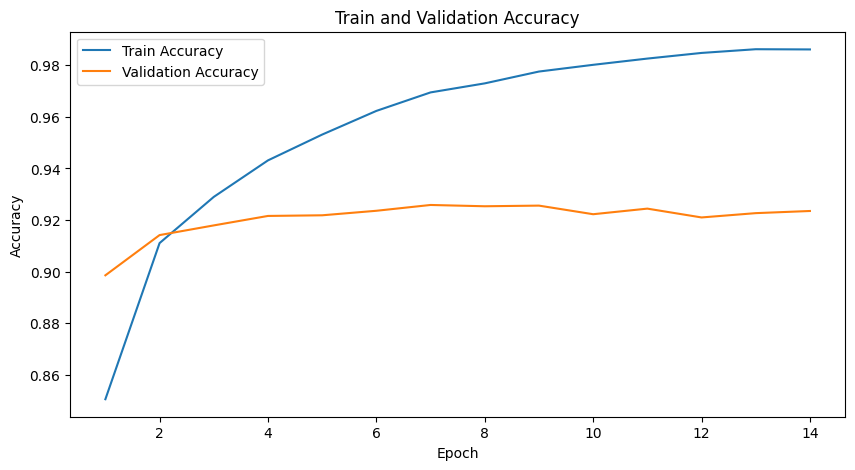

In [39]:
# 4. 학습 루프 준비
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

num_epochs = 20 #epoch 수는 20 (학습횟수 20회)
early_stop_patience = 5 #조기 종료 조건은 검증의 손실 개선이 5번 연속으로 없을 때 종료
best_val_loss = float('inf')
early_stop_counter = 0

# 5. 학습 및 검증 루프
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, criterion, optimizer, train_loader)
    val_loss, val_acc = validate(model, criterion, valid_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)  # float 그대로 저장
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_acc:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_acc:.4f}")

    # Early Stopping - 조기종료의 조건
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        save_path = f"./fashion_mnist_cnn_epoch_{epoch+1}.pth"  # CNN용 체크포인트 저장
        save_checkpoint(epoch+1, model, save_path,
                        train_losses, val_losses,
                        train_accuracies, val_accuracies)
    else:
        early_stop_counter += 1

    if early_stop_counter >= early_stop_patience:
        print("Early stopping triggered.")
        break

# 전체 epoch 완료 후 모델 저장
if early_stop_counter < early_stop_patience:
    print("전체 epoch 완료 후 모델 저장")
    save_path = f"./fashion_mnist_cnn_final_epoch_{num_epochs}.pth"
    save_checkpoint(num_epochs, model, save_path,
                    train_losses, val_losses,
                    train_accuracies, val_accuracies)

# 6. 손실 그래프 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# 7. 정확도 그래프 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

### 상황설명

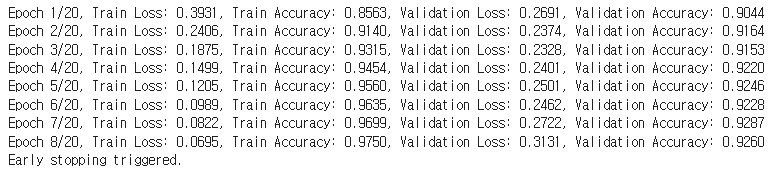

이번에도 MLP와 마찬가지로 Train Loss는 epoch를 지나가면서 점점 줄어들지만, Validation Loss는 Epoch8부터 다시 증가하는 '과적합'이 일어나는 것을 알 수 있어요.

In [41]:
# 1. 모델 가중치 로드
load_path = "./fashion_mnist_cnn_epoch_9.pth"  # 로컬에 저장한 모델 파일
checkpoint = torch.load(load_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

test_loss = 0.0
test_corrects = 0
criterion = nn.CrossEntropyLoss() #다중분류의 손실함수
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        batch_size = labels.size(0)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * batch_size
        preds = torch.argmax(outputs, dim=1)
        test_corrects += torch.sum(preds == labels).item()
        total_samples += batch_size

# 3. 평균 손실과 정확도 계산
test_loss /= total_samples
test_acc = test_corrects / total_samples

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.3880, Test Accuracy: 0.9176


### 성능지표 계산

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np

# 모델을 평가 모드로
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 클래스 이름 리스트
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 1️ 분류 보고서
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# 2️ 혼동 행렬
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.86      0.86      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.87      0.90      0.89      1000
       Dress       0.91      0.92      0.92      1000
        Coat       0.89      0.84      0.86      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.76      0.77      0.76      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Confusion Matrix:
[[863   0  12  20   3   1  96   0   5   0]
 [  2 985   0   8   0   0   2   0   3   0]
 [ 16   1 900   5  37   0  41   0   0   0]
 [ 20   2   8 919  16   0  33   0   2   0]
 [  2   0  56  26 843   0  7

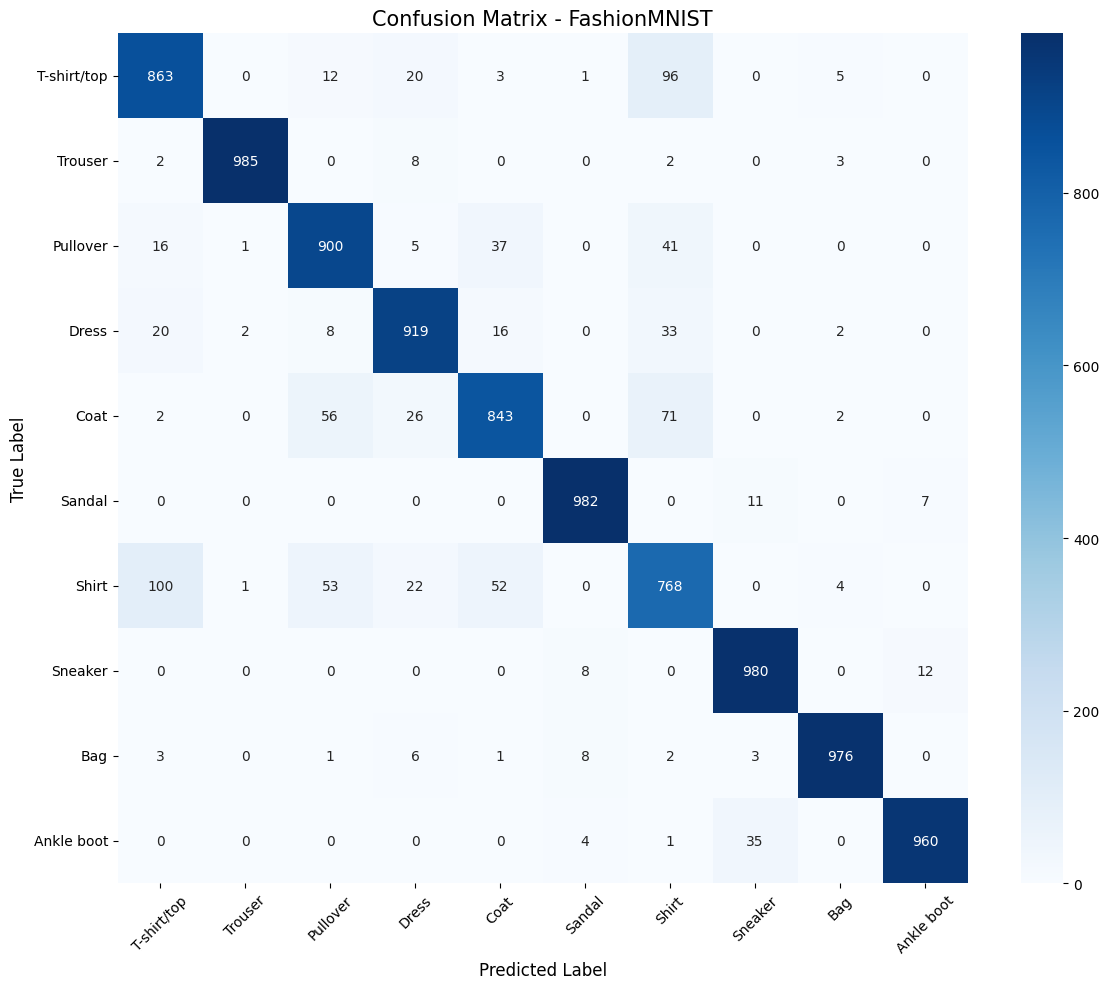

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1️ 혼동 행렬 계산
cm = confusion_matrix(all_labels, all_preds)

# 2️ 클래스 이름
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 3️ 혼동 행렬 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes,
            cbar=True)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - FashionMNIST', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### test 데이터셋에서 예측값과 정답을 시각화를 통해 비교

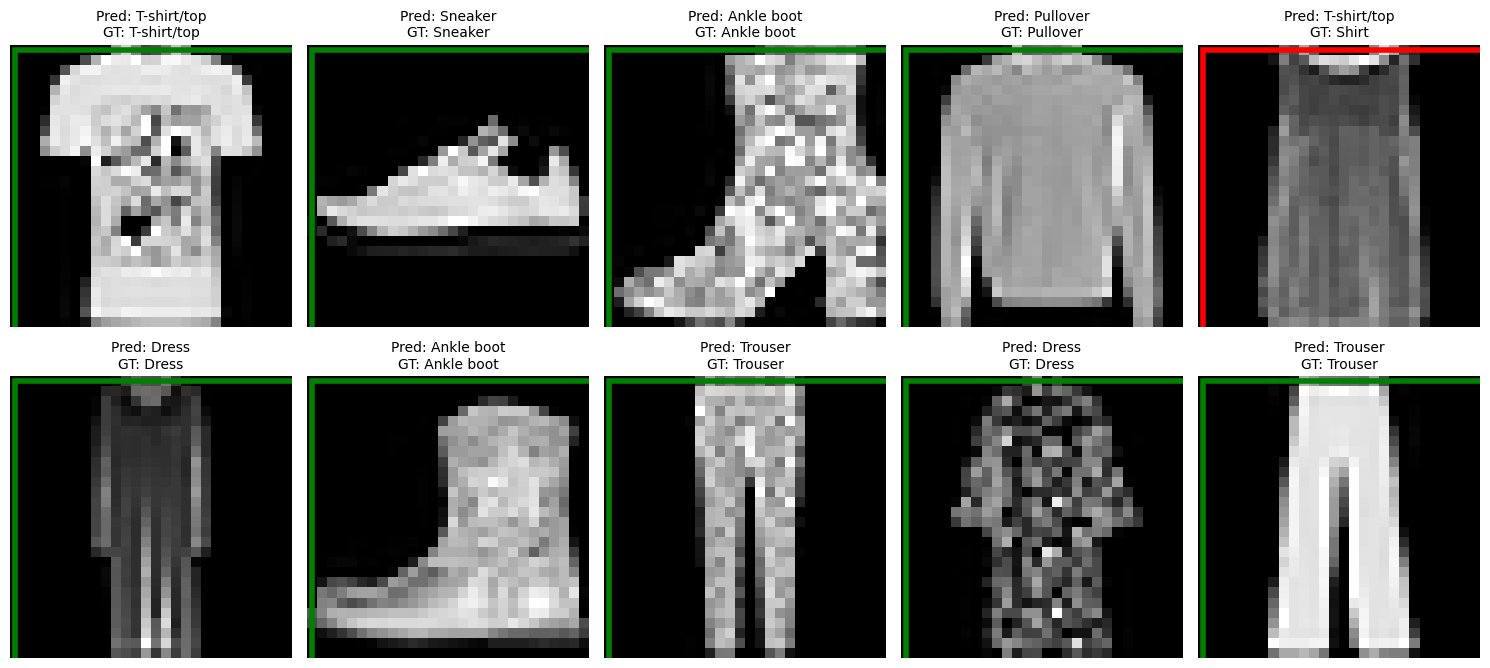

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np

# 모델 평가 모드
model.eval()

# 2행 5열 subplot 설정
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.ravel()

# 테스트 데이터셋에서 무작위 10개 선택
random_indices = random.sample(range(len(test_dataset)), 10)

for i, idx in enumerate(random_indices):
    image, label = test_dataset[idx]       # image: tensor, label: int
    input_tensor = image.unsqueeze(0).to(device)  # 배치 차원 추가

    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    # 클래스 이름
    pred_class = classes[pred]
    gt_class = classes[label]

    # 이미지 처리: 1채널 흑백 → 2D 배열
    image_np = image.squeeze().cpu().numpy()

    # 이미지 표시
    axes[i].imshow(image_np, cmap='gray')
    axes[i].axis("off")
    axes[i].set_title(f"Pred: {pred_class}\nGT: {gt_class}", fontsize=10)

    # 테두리 색상: 정답이면 초록, 오답이면 빨강
    color = "green" if pred == label else "red"
    h, w = image_np.shape
    rect = patches.Rectangle((0, 0), w, h, linewidth=4, edgecolor=color, facecolor='none')
    axes[i].add_patch(rect)

plt.tight_layout()
plt.show()


## 3. 전이학습을 통한 이미지 분류

CNN에서는 이미지의 공간적 특징을 자동으로 추출하는 것이 특징이고, 데이터셋 전체로 학습한다는 특징이 있어요.

그리고 전이학습은 이미 큰 데이터셋으로 학습된 CNN 모델의 특징 추출 능력을 활용하는 방식입니다.

따라서 학습 데이터가 적어도 좋은 성능을 도출할 수 있고, 학습 시간을 단축시키며, 작은 데이터셋으로도 높은 정확도를 유지할 수 있어요.

### 데이터셋 불러오기 및 train/valid/test 분리

In [45]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fashion-MNIST dataset 경로
data_path = "./data"

# 기본 transform (추후 augmentation 포함)
basic_transform = torchvision.transforms.Compose([
    transforms.ToTensor() #Tensor로 만들기
])

# 전체 train 데이터 불러오기
full_train_dataset = datasets.FashionMNIST(root=data_path, train=True, download=True, transform=basic_transform)

# train/validation 분리 (예: 90% train, 10% valid)
train_size = int(0.9 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size])

# test 데이터셋
test_dataset = datasets.FashionMNIST(root=data_path, train=False, download=True, transform=basic_transform)

print(f"Train size: {len(train_dataset)}, Valid size: {len(valid_dataset)}, Test size: {len(test_dataset)}")

Train size: 54000, Valid size: 6000, Test size: 10000


### 특정 이미지 확인 및 transform 전/후 비교



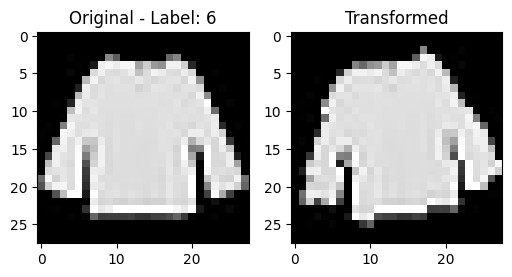

In [46]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np

# 예시 이미지 확인
idx = 0
img, label = train_dataset[idx]  # img는 Tensor 형태
# Tensor -> PIL Image
img_pil = transforms.ToPILImage()(img)

# 시각화 전 이미지 (원본)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title(f"Original - Label: {label}")
plt.imshow(img.squeeze(), cmap="gray")

# 간단한 transform 정의 (PIL Image 기반)
transform_example = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor() #Tensor화 시키기
])

# transform 적용
img_transformed = transform_example(img_pil)

# transform 후 이미지 시각화
plt.subplot(1,2,2)
plt.title("Transformed")
plt.imshow(img_transformed.permute(1,2,0).squeeze(), cmap="gray")  # Tensor -> numpy 형식으로
plt.show()

### 데이터 augmentationi & transform 정의

In [47]:
train_transform = torchvision.transforms.Compose([
    transforms.Resize((224,224)),  # Pretrained 모델 입력 크기 맞춤
    transforms.Grayscale(num_output_channels=3),  # 1채널 -> 3채널
    transforms.RandomHorizontalFlip(), #랜덤으로 좌우 뒤집기
    transforms.RandomRotation(15), #랜덤으로 -15도 ~ 15도 회전
    transforms.ToTensor(), #이미지를 Tensor로 변환
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3) #정규화
])

valid_test_transform = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# transform 적용
train_dataset.dataset.transform = train_transform
valid_dataset.dataset.transform = valid_test_transform
test_dataset.transform = valid_test_transform

### DataLoader 정의

In [48]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### train, validate, save_checpoint 함수

MLP, CNN 모델 과정에서 사용했던 train, validate, save_checkpoint 함수를 그대로 사용하면 됩니다.

### 모델 준비

In [49]:
import torch.nn as nn
from torchvision import models

# pretrained ResNet18 불러오기
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# 마지막 fc layer 수정 (Fashion-MNIST: 10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

### 손실함수, 옵티마이저 정의

In [50]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #다중 분류 손실함수인 크로스엔트로피 사용
optimizer = optim.Adam(model.parameters(), lr=1e-4) #옵티마이저는 Adam 사용

### 학습 시작

In [51]:
from tqdm import tqdm

num_epochs = 5 #전체 횟수는 5번
best_valid_acc = 0.0

for epoch in range(num_epochs):
    # --- Train ---
    model.train() #훈련을 시켜야합니다
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward() #역전파 수행
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += val_loss + loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_valid_acc: #최고 검증 정확도 모델 저장
        best_valid_acc = val_acc
        torch.save(model.state_dict(), "best_fashion_mnist_resnet18.pth")

100%|██████████| 844/844 [04:09<00:00,  3.39it/s]


Epoch [1/5] | Train Loss: 0.2630, Train Acc: 0.9086 | Val Loss: 23007792111639194803109888.0000, Val Acc: 0.9340


100%|██████████| 844/844 [04:06<00:00,  3.42it/s]


Epoch [2/5] | Train Loss: 0.1483, Train Acc: 0.9468 | Val Loss: 21417581126961691105427456.0000, Val Acc: 0.9433


100%|██████████| 844/844 [04:06<00:00,  3.42it/s]


Epoch [3/5] | Train Loss: 0.1061, Train Acc: 0.9624 | Val Loss: 18200240387442481408507904.0000, Val Acc: 0.9432


100%|██████████| 844/844 [04:06<00:00,  3.43it/s]


Epoch [4/5] | Train Loss: 0.0746, Train Acc: 0.9733 | Val Loss: 18290090680109038286405632.0000, Val Acc: 0.9368


100%|██████████| 844/844 [04:06<00:00,  3.43it/s]


Epoch [5/5] | Train Loss: 0.0498, Train Acc: 0.9827 | Val Loss: 17258029883664060509061120.0000, Val Acc: 0.9495


### 성능 지표 계산

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.91      0.89      0.90      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.91      0.94      0.93      1000
       Dress       0.94      0.94      0.94      1000
        Coat       0.93      0.93      0.93      1000
      Sandal       1.00      0.98      0.99      1000
       Shirt       0.85      0.84      0.84      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       1.00      0.99      0.99      1000
  Ankle boot       0.97      0.98      0.98      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



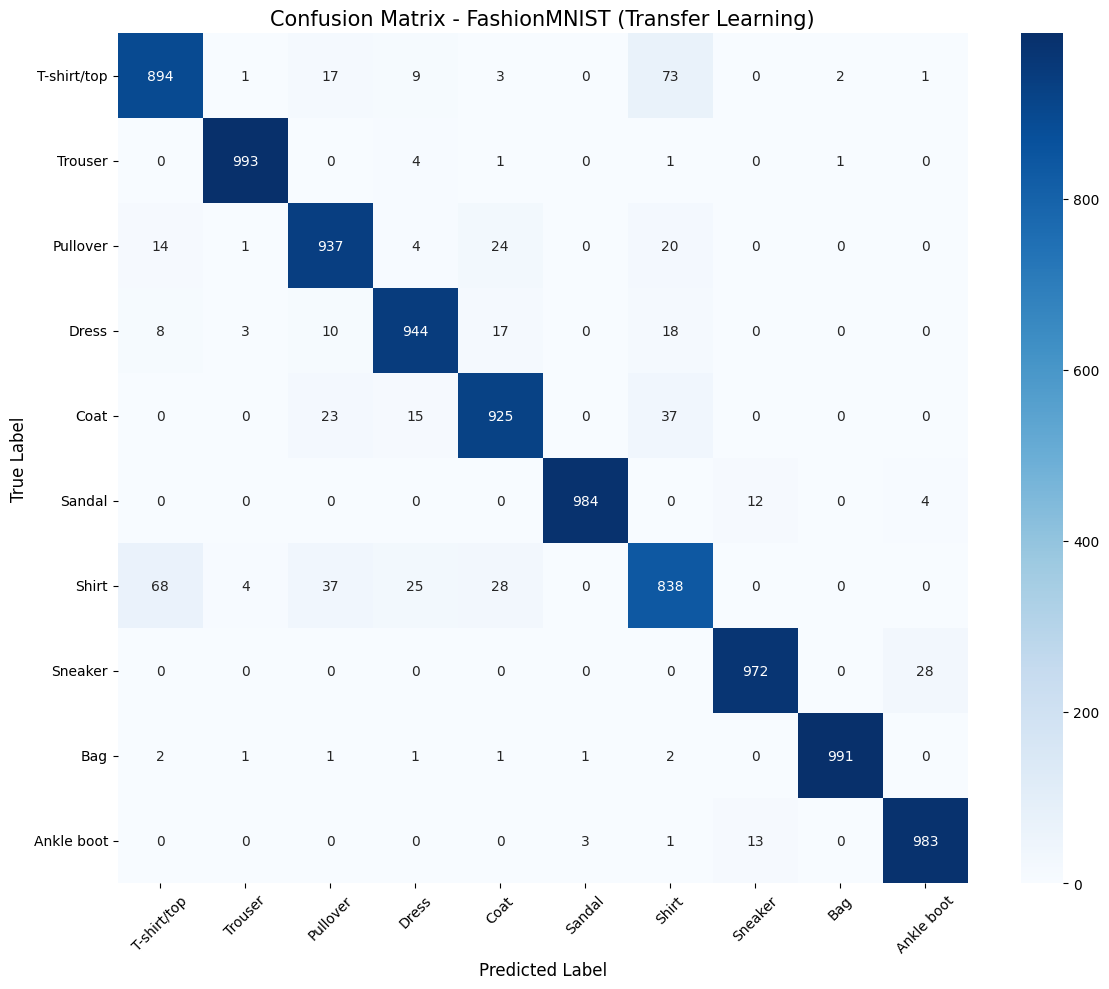

In [52]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# 1. 모델 평가 모드
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # 1채널 그대로 입력
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ---------------------------
# 2. Fashion-MNIST 클래스 이름
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# ---------------------------
# 3. 분류 보고서 출력
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# ---------------------------
# 4. 혼동 행렬 계산 및 시각화
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes,
            cbar=True)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - FashionMNIST (Transfer Learning)', fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### test 데이터셋에서 예측값과 정답을 시각화를 통해 비교

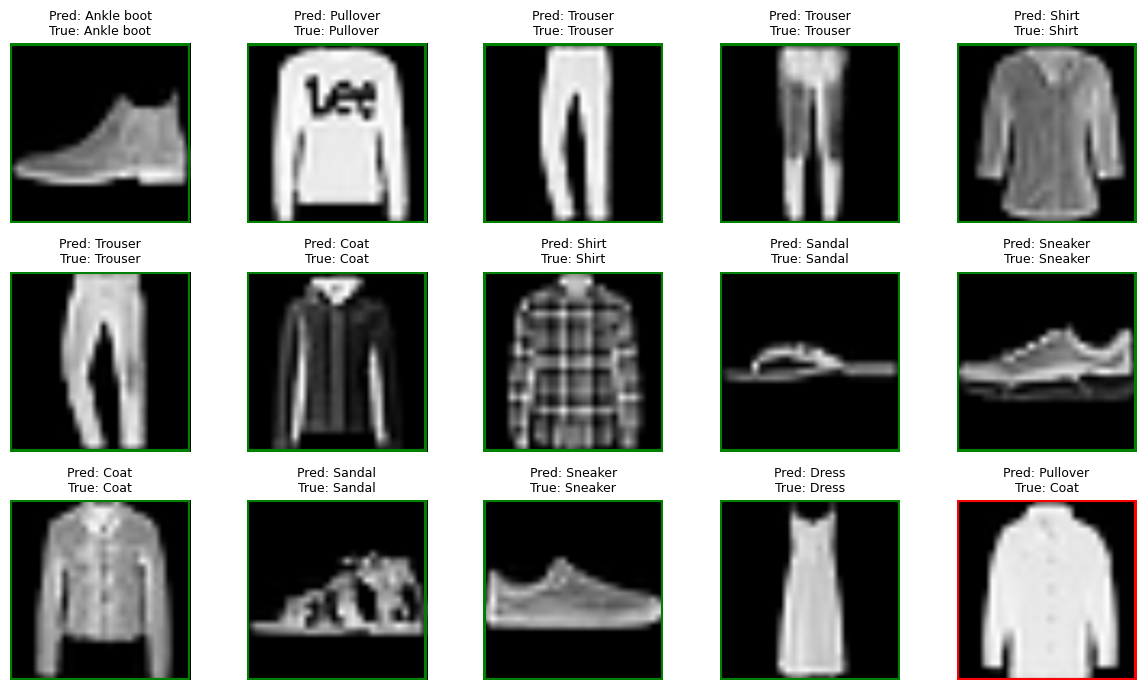

In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

classes = test_dataset.classes
fig, axes = plt.subplots(3,5, figsize=(12,7))
axes = axes.flatten()

# 한 배치만 시각화
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

    for j in range(min(len(images), len(axes))):
        img_to_show = images[j].cpu() * 0.5 + 0.5  # denormalize
        axes[j].imshow(img_to_show.permute(1,2,0))
        axes[j].axis('off')

        # 맞으면 초록, 틀리면 빨강
        color = 'green' if preds[j] == labels[j] else 'red'
        rect = patches.Rectangle((0,0), img_to_show.shape[2]-1, img_to_show.shape[1]-1,
                                 linewidth=3, edgecolor=color, facecolor='none')
        axes[j].add_patch(rect)

        axes[j].set_title(f"Pred: {classes[preds[j]]}\nTrue: {classes[labels[j]]}", fontsize=9)
    break  # 첫 배치만 시각화

plt.tight_layout()
plt.show()

## 실습 끝! 고생하셨습니다.